In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42


In [5]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    
    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

def fit_melting_curve(fits, construct, site, kadd_arrhenius = None, agg_mean = False):
    """
    Fit a melting curve for a given construct and site.

    Parameters:
        fits (pd.DataFrame): DataFrame containing the fit data.
        construct (str): The construct name to filter the data.
        site (int): The site number to filter the data.
        kadd_arrhenius (lmfit LinearModel result): The result of the kadd Arrhenius fit.
        agg_mean (bool): Whether to aggregate the data by mean temperature.
            Default is False.  
    Returns:
        tuple: A tuple containing:
            - fits_filt (pd.DataFrame): Filtered DataFrame for the given construct and site.
            - melt_result (lmfit.model.ModelResult): Result of the melting curve fit.
            - smooth_x (np.ndarray): Smoothed x-values for the fitted curve.
            - smooth_y (np.ndarray): Smoothed y-values for the fitted curve.
            - lnkobs_20C (float): Natural log of kobs at 20°C.
            - lnkobs_20C_err (float): Uncertainty in the natural log of kobs at 20°C.
            - lnkadd (float): Natural log of kadd at 20°C.
            - lnkadd_err (float): Uncertainty in the natural log of kadd at 20°C.
            - kadd_curve_x (np.ndarray): x-values for the kadd curve.
            - kadd_curve_y (np.ndarray): y-values for the kadd curve.
    
    """
    fits_filt = fits[(fits['disp_name'] == construct) & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    if agg_mean:
        fits_filt = fits_filt.groupby('temperature').mean().reset_index()

    if kadd_arrhenius is not None:
        # get kadd slope and intercept
        kadd_slope = kadd_arrhenius.params['slope'].value
        kadd_intercept = kadd_arrhenius.params['intercept'].value

        # for drawing upper baseline
        kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        kadd_curve_y = kadd_slope * kadd_curve_x + kadd_intercept

        # calculate lnkadd at 20C
        lnkadd = kadd_arrhenius.eval(x = 1 / (273.15 + 20))
        lnkadd_err = kadd_arrhenius.eval_uncertainty(x = 1 / (273.15 + 20))

        kadd_params = (kadd_slope, kadd_intercept)
        melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'], kadd_params = kadd_params)

    else:
        melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'])

        # for drawing upper baseline
        slope = melt_result.params['c'].value
        intercept = melt_result.params['d'].value
        kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        kadd_curve_y = slope * kadd_curve_x + intercept

        lnkadd = slope * (1 / (273.15 + 20)) + intercept
        lnkadd_err = 0

    smooth_x, smooth_y = calc_smoothed_best_fit(melt_result)

    # calculate lnkobs at 20C
    lnkobs_20C = melt_result.eval(x = 1 / (273.15 + 20))
    lnkobs_20C_err = melt_result.eval_uncertainty(x = 1 / (273.15 + 20))

    return fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y, 

def aggregated_lmfit_melted(fits, sites, disp_name, fit_param = 'log_kobs'):
    # 'log_kobsT' for eyring or 'log_kobs' for arrhenius
    
    all_melted = fits.copy()#[fits['temperature'] > 59]
    # filt name contains "4U_wt" or "4U_a8c"
    all_melted = all_melted[all_melted['disp_name'].str.contains(disp_name)]
    all_melted = all_melted[all_melted['temperature'] > 59]

    all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
    all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']
    all_melted.loc[:, 'log_kobsT'] = all_melted['log_kobs'] + np.log(all_melted['inv_temp'])

    #if disp_name == 'hiv_':
    #    all_melted = all_melted[all_melted['log_kobs'] > -7.75]

    select_melted = all_melted[all_melted['site'].isin(sites)]

    # Compute mean and standard deviation of log_kobs at each inv_temp for weighting
    grouped = select_melted.groupby(['inv_temp', 'disp_name'])[fit_param].agg(['mean', 'std']).reset_index()
    grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

    grouped.plot(x='inv_temp', y='mean', kind='scatter', color = 'black')

    # weighted linear fit
    model = LinearModel()
    params = model.make_params()
    result = model.fit(grouped['mean'], params, x=grouped['inv_temp'], weights=grouped['weight'])
    return result

In [7]:
# Load data

global_fits = '../06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results_withCs.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)


# get experimental info
main_db  = '../06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits.columns

Index(['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2', 'stderr_log_kappa',
       'stderr_log_kdeg', 'stderr_log_fmod_0', 'rg_id', 'temperature',
       'disp_name', 'buffer_id'],
      dtype='object')

4U_A
4U_C
4U_G
No data for 4U_G
hiv_A
hiv_C
hiv_G


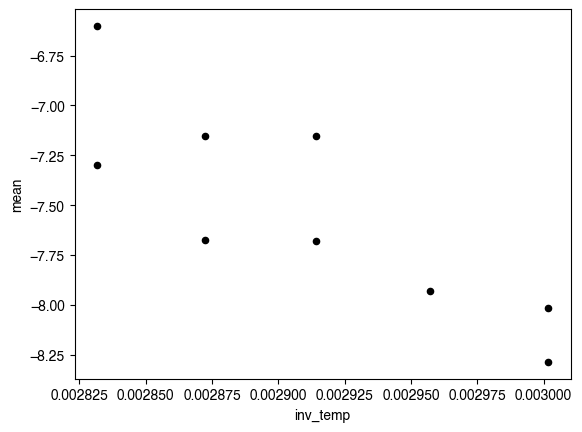

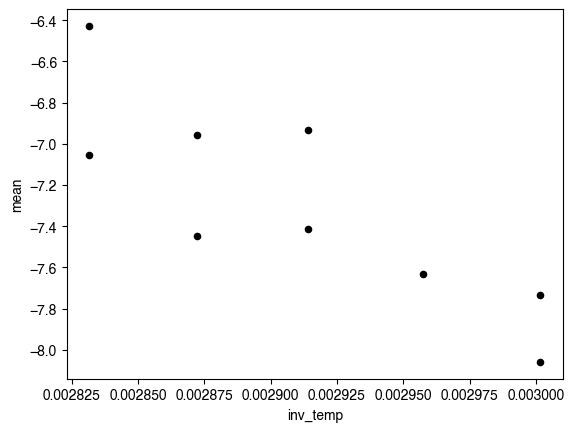

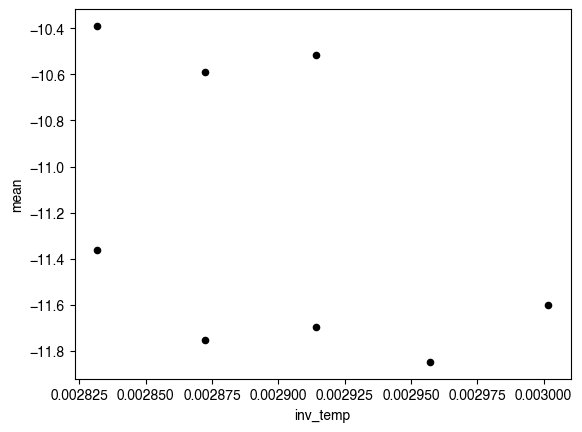

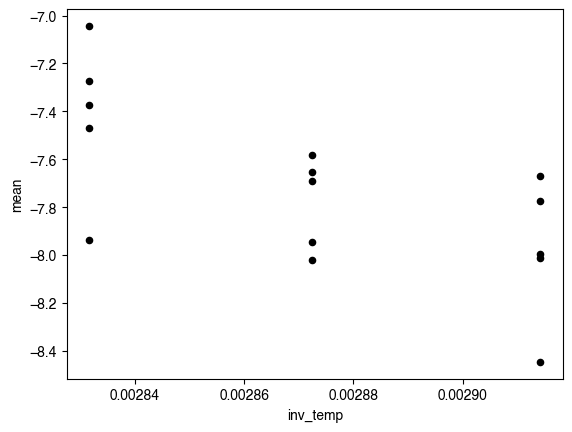

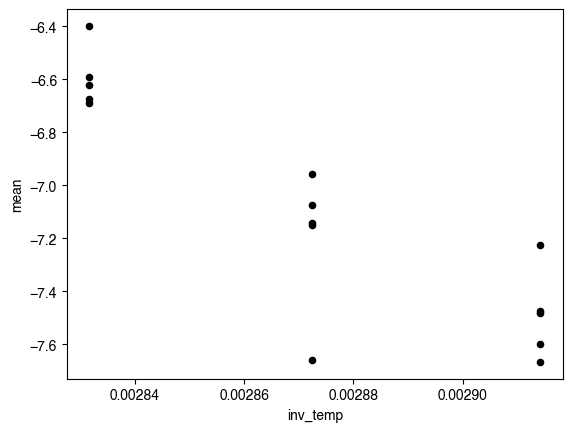

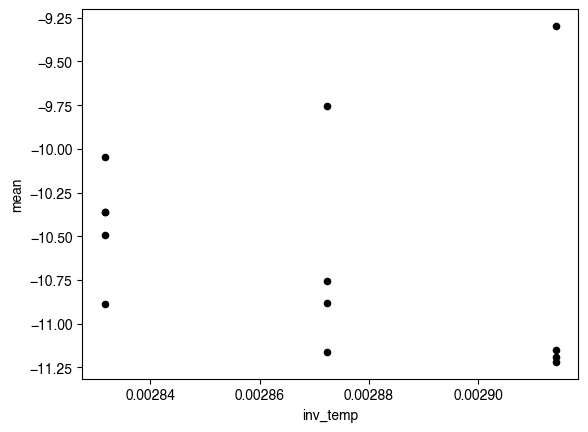

In [9]:
sites_dict_hiv = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62], 
                  'G': [17, 18, 21, 26, 28, 32, 33, 34, 36, 43]}
sites_dict_4U = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 21, 31]}

sites_dict = {'hiv_': sites_dict_hiv, '4U_': sites_dict_4U}

arrhenius_aggfits = {}
for construct in ['4U_', 'hiv_']:
    for base in ['A', 'C', 'G']:
        dict_key = f'{construct}{base}'
        print(dict_key)
        try:
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict[construct][base], construct, 'log_kobs')
        except:
            print(f'No data for {dict_key}')
            continue

# Load NTP data
all_fit_params = '../05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8'].copy()
peak8['lnkaddT'] = peak8['lnkadd'] + np.log(peak8['1/T'])

for ntp in ['ATP', 'CTP', 'GTP']:
    peak8_ntp = peak8[peak8['ntp'] == ntp]
    dict_key = f'nmr_{ntp[0]}'

    # arrhenius
    model = LinearModel()
    params = model.make_params()
    result = model.fit(peak8_ntp['lnkadd'], params, x=peak8_ntp['1/T'])
    arrhenius_aggfits[dict_key] = result

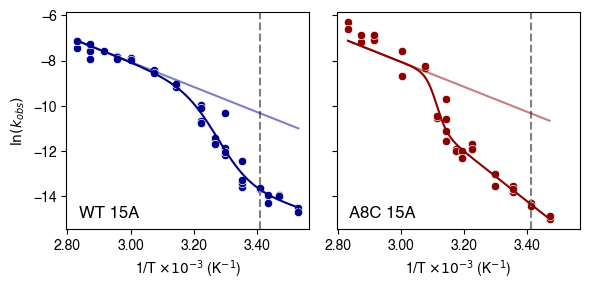

In [10]:
# filter disp_name "4U_wt"
site = 15

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, arrhenius_aggfits['4U_A'])
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site, arrhenius_aggfits['4U_A'])

# 4U_A aggregated arrhenius linear fit result

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/ind_kadd_fit.pdf')
plt.show()

In [141]:
import scipy.constants as sc

def calculate_lnkadd(melt_fit, temp):
    # temp in C
    inv_temp = 1 / (273.15 + temp)
    slope = melt_fit.params['c'].value
    intercept = melt_fit.params['d'].value
    lnkadd = slope * inv_temp + intercept
    return lnkadd

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

def plot_dG_v_temp(site, construct, ax):

    sites = [7, 8, 15, 16, 18, 22, 26, 29, 34]
    # tab10 colors
    cmap = plt.get_cmap('tab10')
    positions = np.linspace(0, 1, len(sites))
    site_colors = {site: cmap(pos) for site, pos in zip(sites, positions)}

    # perform fits
    fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, construct, site, arrhenius_aggfits['4U_A'])
    fits_filt['lnkadd'] = fits_filt.apply(lambda row: calculate_lnkadd(melt_result, row['temperature']), axis=1)
    fits_filt['lnKKp1'] = fits_filt['log_kobs'] - fits_filt['lnkadd']
    fits_filt['KKp1'] = np.exp(fits_filt['lnKKp1'])
    fits_filt['K'] = fits_filt['KKp1'] / (1 - fits_filt['KKp1'])
    fits_filt['dG'] = -(sc.R / 4184) * (fits_filt['temperature'] + 273.15) * np.log(fits_filt['K'])

    fit_lnKKp1 = smooth_y - kadd_curve_y
    fit_KKp1 = np.exp(fit_lnKKp1)
    fit_K = fit_KKp1 / (1 - fit_KKp1)
    fit_dG = -(sc.R / 4184) * (1 / smooth_x) * np.log(fit_K)
    fit_temps = (1 / smooth_x) - 273.15


    # Group by temperature, compute mean dG, std, and stderr
    grouped = fits_filt.groupby('temperature')['dG'].agg(['mean', 'std', 'count'])
    grouped['stderr'] = grouped['std'] / np.sqrt(grouped['count'])

    # Plot the line first and get its color
    line, = ax.plot(fit_temps, fit_dG, label=f'{site}A', linewidth = 0.75, color=site_colors[site])
    line_color = line.get_color()

    # Use the same color for error bars
    ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['stderr'], fmt='o', color=line_color, markersize=4)

    # Labels and legend
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('ΔG (kcal/mol)')
    ax.legend()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


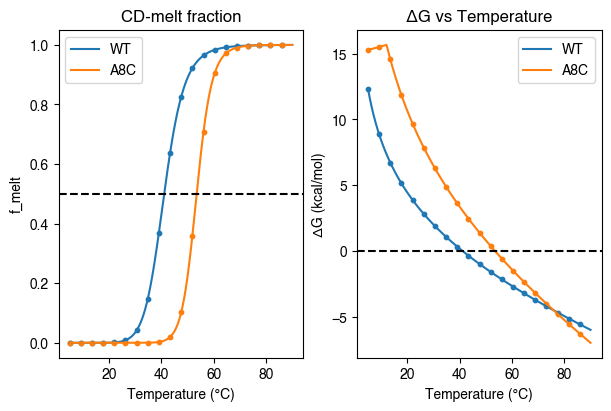

In [142]:
# ---- Constants ----
R_KCAL = 1.987204258e-3  # kcal/mol/K
EPS = 1e-12              # numerical guard to avoid div-by-zero or log(0)

# ---- CD-melt model ----
def cd_melt_f(T_celsius, Tm_celsius, b, a=1.0):
    """
    CD melt fraction f(T) = a*T^b / (Tm^b + T^b)
    T and Tm are both in °C (use consistently with the provided Tm values).
    """
    T = np.asarray(T_celsius, dtype=float)
    # Guard: if temperatures include negatives, raise a helpful error (model expects positive for T^b)
    if np.any(T < 0):
        raise ValueError("This implementation expects T in °C >= 0 for T^b. "
                         "If you need sub-zero temps, consider redefining the model on Kelvin.")
    numerator = a * np.power(T, b)
    denom = np.power(Tm_celsius, b) + np.power(T, b)
    f = numerator / np.maximum(denom, EPS)
    # Clip to (0,1) for numerical stability
    return np.clip(f, EPS, 1 - EPS)

def f_to_K(f):
    """K = f / (1 - f) with numerical guards."""
    f = np.asarray(f, dtype=float)
    return f / np.maximum(1.0 - f, EPS)

def dG_from_K(K, T_celsius):
    """ΔG (kcal/mol) = -R * T(K) * ln K."""
    T_kelvin = np.asarray(T_celsius, dtype=float) + 273.15
    return -R_KCAL * T_kelvin * np.log(np.maximum(K, EPS))

# ---- Parameters (from prompt) ----
params = {
    "WT":  {"b": 10.6, "Tm_c": 41.1, "a": 1.0},
    "A8C": {"b": 18.6, "Tm_c": 53.5, "a": 1.0},
}

# ---- Temperature grid (°C) ----
T_c = np.linspace(5.0, 90.0, 400)

# ---- Compute f_melt, K, and ΔG for each construct ----
results = {}
for name, p in params.items():
    f_melt = cd_melt_f(T_c, Tm_celsius=p["Tm_c"], b=p["b"], a=p["a"])
    K = f_to_K(f_melt)
    dG = dG_from_K(K, T_c)
    results[name] = {"T_c": T_c, "f_melt": f_melt, "K": K, "dG": dG}

# ---- Plotting ----
fig, ax = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True)

# Panel 1: CD melt fraction vs Temperature
for i, (name, res) in enumerate(results.items()):
    line, = ax[0].plot(res["T_c"], res["f_melt"], label=name)      # get line color
    color = line.get_color()
    ax[0].scatter(res["T_c"][::20], res["f_melt"][::20], s=10, color=color)  # sparse markers with same color

ax[0].axhline(0.5, color='black', linestyle='--')

ax[0].set_xlabel("Temperature (°C)")
ax[0].set_ylabel("f_melt")
ax[0].set_title("CD-melt fraction")
ax[0].legend()

# Panel 2: ΔG vs Temperature
for name, res in results.items():
    line, = ax[1].plot(res["T_c"], res["dG"], label=name)
    color = line.get_color()
    ax[1].scatter(res["T_c"][::20], res["dG"][::20], s=10, color=color)

# horizontal line at dG = 0
ax[1].axhline(0, color='black', linestyle='--')
ax[1].set_xlabel("Temperature (°C)")
ax[1].set_ylabel("ΔG (kcal/mol)")
ax[1].set_title("ΔG vs Temperature")
ax[1].legend()
plt.savefig('cd_melt_dG_vs_temp.pdf')
plt.show()

In [143]:
results['WT'].keys()

dict_keys(['T_c', 'f_melt', 'K', 'dG'])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


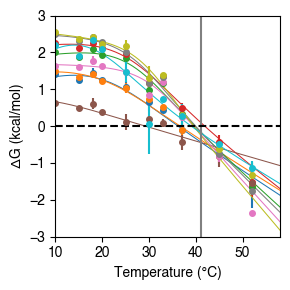

In [155]:
fig, ax = plt.subplots(figsize=(3, 3))

for site in [7, 8, 15, 16, 18, 22, 26, 29, 34]:
    try:
        plot_dG_v_temp(site, '4U_wt', ax)
    except:
        print(f'No data for site {site}')
        continue

# plot dG global from results['WT'] (x: T_c, y: dG) on a second axis
#ax.plot(results['WT']['T_c'], results['WT']['dG'], label='CD melt global', color='black', linestyle='-')

#vertical line at tm 41.1
ax.axvline(41.1, color='gray', linestyle='-', label='Global Tm')

# horizontal line at y=0
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('ΔG (kcal/mol)')
ax.legend(loc='upper right')
ax.set_ylim(-3, 3)
ax.set_xlim(10, 58)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
plt.tight_layout()
plt.savefig('dG_vs_temp_4U_wt.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


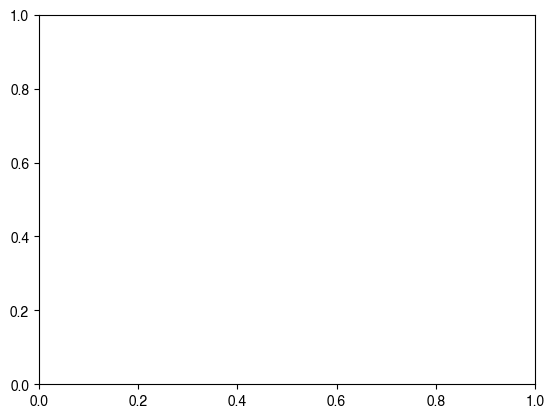

<Figure size 300x400 with 0 Axes>

In [156]:
fig, ax = plt.subplots()
fig_leg = plt.figure(figsize=(3, 4))  # tweak size as needed
fig_leg.legend(handles, labels, loc='center', frameon=False)
fig_leg.tight_layout()
fig_leg.savefig('dG_vs_temp_legend.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


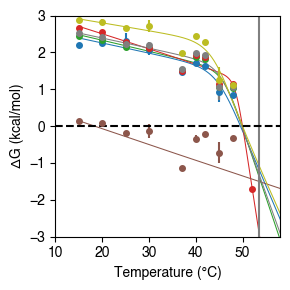

In [157]:
fig, ax = plt.subplots(figsize=(3, 3))

for site in [7, 15, 16, 18, 26, 29]:
    try:
        plot_dG_v_temp(site, '4U_a8c', ax)
    except:
        print(f'No data for site {site}')
        continue

# plot dG global from results['WT'] (x: T_c, y: dG) on a second axis
#ax.plot(results['A8C']['T_c'], results['A8C']['dG'], label='CD melt global', color='black', linestyle='-')

# vertical line at 53.5C global Tm
ax.axvline(53.5, color='gray', linestyle='-', label='Global Tm')

# horizontal line at y=0
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('ΔG (kcal/mol)')
ax.set_ylim(-3, 3)
ax.set_xlim(10, 58)

# remove legend
ax.legend().remove()
plt.tight_layout()
plt.savefig('dG_vs_temp_4U_a8c.pdf')